In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Import blg data
blg_data = dict()
for ws in ['px_last', 'earnings', 'pe_ratio']:
    blg_data[ws] = pd.read_excel('blg_data.xlsx', sheet_name=ws)
    blg_data[ws]['Dates'] = pd.to_datetime(blg_data[ws]['Dates'])
    blg_data[ws].set_index('Dates', inplace=True)
blg_data[ws].tail()

A UN Equity  AAL UW Equity  AAP UN Equity  AAPL UW Equity  \
Dates                                                                   
2020-08-31      38.0625        54.2549        21.3776         39.2589   
2020-09-30      38.2596        54.2549        20.9933         35.5656   
2020-10-31      37.7040        54.2549        18.3488         33.4312   
2020-11-30      43.1736        54.2549        18.4011         36.5606   
2020-12-31      43.7608        54.2549        19.6233         36.0192   

            ABBV UN Equity  ABC UN Equity  ABMD UW Equity  ABT UN Equity  \
Dates                                                                      
2020-08-31         12.1061        13.4772         82.0083        54.3576   
2020-09-30         11.4940        12.9063         71.0299        53.7960   
2020-10-31         11.1673        12.7931         64.5745        51.9572   
2020-11-30         13.7235        13.7305         70.2711        53.4945   
2020-12-31         13.8341        12.4246         81.1892        43.7604   

            ACN UN Equity  ADBE UW Equity  ...  XLNX UW Equity  XOM UN Equity  \
Dates                                      ...                                  
2020-08-31        31.5526         64.8390  ...         36.0105        49.1094   
2020-09-30        29.7194         61.9392  ...         37.4508        42.1500   
2020-10-31        28.5253         56.4668  ...         42.6423        42.1500   
2020-11-30        31.7955         44.0522  ...         52.2924        42.1500   
2020-12-31        33.3426         46.0455  ...         50.9344        42.1500   

            XRAY UW Equity  XRX UN Equity  XYL UN Equity  YUM UN Equity  \
Dates                                                                     
2020-08-31        908.1341         8.1705        38.1434        33.0048   
2020-09-30        362.6217        12.2339        44.1829        30.3595   
2020-10-31        391.3130        11.3279        45.7691        31.0346   
2020-11-30        421.9945        14.2674        50.4069        35.1812   
2020-12-31        434.1841        30.6436        49.2019        34.9975   

            ZBH UN Equity  ZBRA UW Equity  ZION UW Equity  ZTS UN Equity  
Dates                                                                     
2020-08-31        40.6459         28.0291         11.8342        43.9195  
2020-09-30        38.5557         25.2752         11.2511        43.2078  
2020-10-31        37.4115         28.3968         12.4255        41.4259  
2020-11-30        42.2317         37.8858         14.8589        41.9040  
2020-12-31        46.0134         35.8500         13.7377        43.9627  

[5 rows x 505 columns]

In [3]:
# Contruct dfs with 1-year average PE, 1 year earnings growth, 1 (past) year price growth, 1 (actual) year price growth.
# Sampling every January.
# function to populate
def pop_list(t, t_prior, df, l_list, operation):
    select_period = (df.index<=t)*(df.index>=t_prior)
    if operation=='mean':
        l_list.append(df[select_period].mean().values)
    elif operation=='ln chg':
        l_list.append(np.log(df[select_period].values[-1]/df[select_period].values[0]))
    elif operation=='last':
        l_list.append(df[select_period].values[-1])
    else:
        raise KeyError
    return l_list
# populate lists
list_dates, list_pe, list_e_g, list_r_t = [], [], [], []
t_prior = blg_data['px_last'].index[0] 
for t in blg_data['px_last'].index:
    if t.month == 1 and t.year > 2010:
        list_dates.append(t)
        list_r_t = pop_list(t, t_prior, blg_data['px_last'], list_r_t, 'ln chg')
        list_e_g = pop_list(t, t_prior, blg_data['earnings'], list_e_g, 'last')
        list_pe = pop_list(t, t_prior, blg_data['pe_ratio'], list_pe, 'mean')
        t_prior = t
# convert to dataframe
df_r_t = pd.DataFrame(list_r_t, columns = blg_data['px_last'].columns, index=[i for i in list_dates])
df_e_g = pd.DataFrame(list_e_g, columns = blg_data['earnings'].columns, index=[i for i in list_dates])
df_pe = pd.DataFrame(list_pe, columns = blg_data['pe_ratio'].columns, index=[i for i in list_dates])

In [4]:
# compute percentiles
list_pc_r_t = [df_r_t.apply(lambda x: np.percentile(x[~np.isnan(x)], 25), axis=1).values, df_r_t.apply(lambda x: np.percentile(x[~np.isnan(x)], 75), axis=1).values]
list_pc_e_g = [df_e_g.apply(lambda x: np.percentile(x[~np.isnan(x)], 25), axis=1).values, df_e_g.apply(lambda x: np.percentile(x[~np.isnan(x)], 75), axis=1).values]
list_pc_pe = [df_pe.apply(lambda x: np.percentile(x[~np.isnan(x)], 25), axis=1).values, df_pe.apply(lambda x: np.percentile(x[~np.isnan(x)], 75), axis=1).values]
# convert to dataframe
df_pc_r_t = pd.DataFrame(np.array(list_pc_r_t).T, columns = ['25th', '75th'], index=[i for i in list_dates])
df_pc_e_g = pd.DataFrame(np.array(list_pc_e_g).T, columns = ['25th', '75th'], index=[i for i in list_dates])
df_pc_pe = pd.DataFrame(np.array(list_pc_pe).T, columns = ['25th', '75th'], index=[i for i in list_dates])

In [5]:
# generate signals
list_pc_r_t_signal, list_pc_e_g_signal, list_pc_pe_signal = [], [], []
for asset in df_r_t.keys():
    # based on returns
    list_pc_r_t_signal.append(((df_r_t[asset]>df_pc_r_t['75th'])*1 - (df_r_t[asset]<df_pc_r_t['25th'])*1).values)
    # based on earnings
    list_pc_e_g_signal.append(((df_e_g[asset]>df_pc_e_g['75th'])*1 - (df_e_g[asset]<df_pc_e_g['25th'])*1).values)
    # based on P/E
    list_pc_pe_signal.append(-((df_pe[asset]>df_pc_pe['75th'])*1 - (df_pe[asset]<df_pc_pe['25th'])*1).values)
# convert to dataframes
list_dates = df_pc_r_t.index
df_r_t_signal = pd.DataFrame(np.array(list_pc_r_t_signal).T, columns = df_r_t.columns, index=[i for i in list_dates])
df_e_g_signal = pd.DataFrame(np.array(list_pc_e_g_signal).T, columns = df_e_g.columns, index=[i for i in list_dates])
df_pe_signal = pd.DataFrame(np.array(list_pc_pe_signal).T, columns = df_pe.columns, index=[i for i in list_dates])

In [6]:
# visualize one
df_pe_signal.head(2)

A UN Equity  AAL UW Equity  AAP UN Equity  AAPL UW Equity  \
2011-01-31            0              0              0               0   
2012-01-31            1              0              0               0   

            ABBV UN Equity  ABC UN Equity  ABMD UW Equity  ABT UN Equity  \
2011-01-31               0              0               0              1   
2012-01-31               0              0               0              1   

            ACN UN Equity  ADBE UW Equity  ...  XLNX UW Equity  XOM UN Equity  \
2011-01-31              0              -1  ...               0              1   
2012-01-31              0               0  ...               0              1   

            XRAY UW Equity  XRX UN Equity  XYL UN Equity  YUM UN Equity  \
2011-01-31               0              1              0              1   
2012-01-31               0              1              1              0   

            ZBH UN Equity  ZBRA UW Equity  ZION UW Equity  ZTS UN Equity  
2011-01-31              0               0               0              0  
2012-01-31              0               0               0              0  

[2 rows x 505 columns]

In [7]:
# compute forward returns
df_r_t_plus_1 = df_r_t.shift(-1)

In [8]:
# long only returns
long_only_r_momentum = (df_r_t_plus_1*(df_r_t_signal==1))[:-1].apply(lambda x: np.mean(x[~np.isnan(x)]), axis=1)
long_only_r_growth = (df_r_t_plus_1*(df_e_g_signal==1))[:-1].apply(lambda x: np.mean(x[~np.isnan(x)]), axis=1)
long_only_r_value = (df_r_t_plus_1*(df_pe_signal==1))[:-1].apply(lambda x: np.mean(x[~np.isnan(x)]), axis=1)
# long short returns
long_short_r_momentum = (df_r_t_plus_1*(df_r_t_signal==-1))[:-1].apply(lambda x: np.mean(-x[~np.isnan(x)]), axis=1)
long_short_r_growth = (df_r_t_plus_1*(df_e_g_signal==-1))[:-1].apply(lambda x: np.mean(-x[~np.isnan(x)]), axis=1)
long_short_r_value = (df_r_t_plus_1*(df_pe_signal==-1))[:-1].apply(lambda x: np.mean(-x[~np.isnan(x)]), axis=1)
long_short_r_momentum += long_only_r_momentum
long_short_r_growth += long_only_r_growth
long_short_r_value += long_only_r_value

In [9]:
# import sp500 data
df_sp = pd.read_excel('blg_data.xlsx', sheet_name='sp_500')
df_sp['Dates'] = pd.to_datetime(df_sp['Dates'])
df_sp.set_index('Dates', inplace=True)
# compute yearly returns
list_dates, list_sp_r = [], []
t_prior = df_sp.index[0] 
for t in df_sp.index:
    if t.month == 1 and t.year > 2011:
        list_dates.append(t)
        list_sp_r = pop_list(t, t_prior, df_sp, list_sp_r, 'ln chg')
        t_prior = t

In [10]:
# datafames long only
df_long = pd.DataFrame(list_sp_r, columns = ['sp 500'], index=[i for i in list_dates])
df_long['momentum'] = long_only_r_momentum.values
df_long['growth'] = long_only_r_growth.values
df_long['value'] = long_only_r_value.values
# datafames long short
df_long_short = pd.DataFrame(list_sp_r, columns = ['sp 500'], index=[i for i in list_dates])
df_long_short['momentum'] = long_short_r_momentum.values
df_long_short['growth'] = long_short_r_growth.values
df_long_short['value'] = long_short_r_value.values

Portfolio evolution and end of value long only
              sp 500  momentum    growth     value
2020-01-31  2.507946  1.341584  1.334878  1.224173


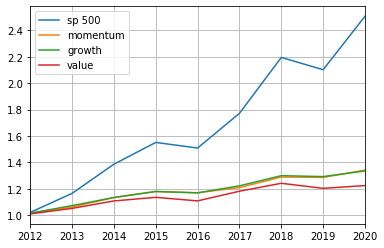

In [11]:
print('Portfolio evolution and end of value long only')
df_long_port_evol = df_long.cumsum().apply(np.exp)
print(df_long_port_evol.tail(1))
df_long_port_evol.plot()
plt.grid()

Portfolio evolution and end of value long short
            momentum   growth     value
2020-01-31  1.076265  1.10092  0.922785


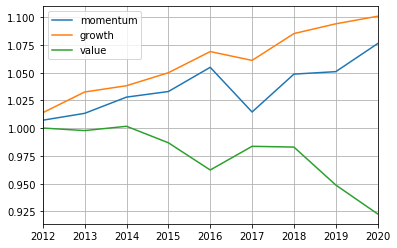

In [12]:
print('Portfolio evolution and end of value long short')
df_long_short_port_evol = df_long_short.drop(['sp 500'], axis=1).cumsum().apply(np.exp)
print(df_long_short_port_evol.tail(1))
df_long_short_port_evol.plot()
plt.grid()